In [1]:
# imports
import numpy as np
import pandas as pd
import pickle
import string
import matplotlib.pyplot as plt
from ast import literal_eval
from operator import index
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud
from scipy.stats import norm

In [2]:
df_test = pd.read_csv(r'../data/test_tokenized.csv')
explanation_df = pd.read_csv(r'../data/explanation_df.csv')

overlap_df = explanation_df.copy()
overlap_df.drop(columns=['lime', 'lime_accuracy'], inplace=True)
overlap_df

,df_test_index,post,label,ig,truncated,pred,ig_accuracy
0,3,The weather in this part of the globe is once ...,1,"[('[CLS]', 0.0), ('the', -0.03305793469461231)...",The weather in this part of the globe is once ...,1,0.452370
1,6,sometimes in life we get so excited about what...,1,"[('[CLS]', 0.0), ('sometimes', -0.002747916593...",sometimes in life we get so excited about what...,1,0.001068
2,7,I had a wonderful encounter with God yesterday...,1,"[('[CLS]', 0.0), ('i', 0.08986844054184116), (...",I had a wonderful encounter with God yesterday...,1,0.109495
3,9,"Did not win on Friday. In fact, only got one d...",0,"[('[CLS]', 0.0), ('did', -0.07365760226623197)...","Did not win on Friday. In fact, only got one d...",0,0.001764
4,13,Meg's recent post on fears and dreams in partn...,1,"[('[CLS]', 0.0), ('meg', 0.18647030206724557),...",Meg's recent post on fears and dreams in partn...,1,0.329056
...,...,...,...,...,...,...,...
195,628,"Ideally, the process for buying a laptop would...",0,"[('[CLS]', 0.0), ('ideally', 0.023534970144603...","Ideally, the process for buying a laptop would...",0,-0.000016
196,630,The big star of today's Apple event in San Fra...,0,"[('[CLS]', 0.0), ('the', 0.1460338751768401), ...",The big star of today's Apple event in San Fra...,0,0.001023
197,632,Well it's that time again! Time for me to com...,0,"[('[CLS]', 0.0), ('well', -0.00637528972289236...",Well it's that time again! Time for me to com...,0,0.100635
198,633,USAA automobile insurance was initially for mi...,1,"[('[CLS]', 0.0), ('usa', 0.011359380673091573)...",USAA automobile insurance was initially for mi...,0,-0.011685


In [3]:
explanation_df['ig'] = explanation_df['ig'].apply(literal_eval)
overlap_df['ig'] = overlap_df['ig'].apply(literal_eval)

In [4]:
overlap_df['post_lengths'] = overlap_df['post'].str.split().str.len()

In [5]:
tokenized = []
for idx in overlap_df.df_test_index:
    tokenized.append(df_test.tokenized[idx])

overlap_df['tokenized'] = tokenized
overlap_df

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized
0,3,The weather in this part of the globe is once ...,1,"[([CLS], 0.0), (the, -0.03305793469461231), (w...",The weather in this part of the globe is once ...,1,0.452370,62,"['weather', 'part', 'globe', 'change', 'slight..."
1,6,sometimes in life we get so excited about what...,1,"[([CLS], 0.0), (sometimes, -0.0027479165931052...",sometimes in life we get so excited about what...,1,0.001068,66,"['sometimes', 'life', 'get', 'excite', 'god', ..."
2,7,I had a wonderful encounter with God yesterday...,1,"[([CLS], 0.0), (i, 0.08986844054184116), (had,...",I had a wonderful encounter with God yesterday...,1,0.109495,431,"['wonderful', 'encounter', 'god', 'yesterday',..."
3,9,"Did not win on Friday. In fact, only got one d...",0,"[([CLS], 0.0), (did, -0.07365760226623197), (n...","Did not win on Friday. In fact, only got one d...",0,0.001764,70,"['win', 'friday', 'fact', 'get', 'one', 'digit..."
4,13,Meg's recent post on fears and dreams in partn...,1,"[([CLS], 0.0), (meg, 0.18647030206724557), (',...",Meg's recent post on fears and dreams in partn...,1,0.329056,340,"['megs', 'recent', 'post', 'fear', 'dream', 'p..."
...,...,...,...,...,...,...,...,...,...
195,628,"Ideally, the process for buying a laptop would...",0,"[([CLS], 0.0), (ideally, 0.02353497014460397),...","Ideally, the process for buying a laptop would...",0,-0.000016,77,"['ideally', 'process', 'buying', 'laptop', 'wo..."
196,630,The big star of today's Apple event in San Fra...,0,"[([CLS], 0.0), (the, 0.1460338751768401), (big...",The big star of today's Apple event in San Fra...,0,0.001023,74,"['big', 'star', 'today', 'apple', 'event', 'sa..."
197,632,Well it's that time again! Time for me to com...,0,"[([CLS], 0.0), (well, -0.0063752897228923685),...",Well it's that time again! Time for me to com...,0,0.100635,330,"['well', 'time', 'time', 'come', 'another', 'e..."
198,633,USAA automobile insurance was initially for mi...,1,"[([CLS], 0.0), (usa, 0.011359380673091573), (#...",USAA automobile insurance was initially for mi...,0,-0.011685,74,"['usaa', 'automobile', 'insurance', 'initially..."


## Load Naive Bayes model

In [7]:
#pipe = pickle.load(open('../models/NB_countVec.sav', 'rb'))
pipe = pickle.load(open('../models/NB_tfIdf.sav', 'rb'))
pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('naive', MultinomialNB(alpha=0.1))])

In [8]:
model = pipe['naive']
vec = pipe['vectorizer']
feat_names = vec.get_feature_names_out()
feat_probs = model.feature_log_prob_
print(feat_names[50000]) #feature name
print(feat_probs[:,50000]) #log probability for feature given classes 0 and 1 (P(feature|male), P(feature|female))

bit ass
[-12.90007048 -13.3818233 ]


In [9]:
X = vec.transform(overlap_df.tokenized)
probs = model.predict_proba(X) #probabilites that a sample belongs to class 0 (male) or class 1 (female) for each sample
print(probs[10])

[0.2486899 0.7513101]


In [10]:
def explain_naive_bayes(sample_id):
    pred = np.argmax(probs[sample_id])
    feat_idxs = X[sample_id].nonzero()[1]

    feat_attributions = []
    for f in feat_idxs:
        male_prob = feat_probs[0,f]
        female_prob = feat_probs[1,f]
        if pred == 0:
            diff = male_prob - female_prob
        else:
            diff = female_prob - male_prob
        feat_attributions.append((feat_names[f],
                                  diff,
                                  male_prob,
                                  female_prob
                                 ))
    
    return feat_attributions, pred

In [11]:
nb_explanations = []
nb_pred = []
for i in overlap_df.index:
    exp, pred = explain_naive_bayes(i)
    nb_explanations.append(exp)
    nb_pred.append(pred)

In [12]:
overlap_df['nb_exp'] = nb_explanations
overlap_df['nb_pred'] = nb_pred
overlap_df

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred
0,3,The weather in this part of the globe is once ...,1,"[([CLS], 0.0), (the, -0.03305793469461231), (w...",The weather in this part of the globe is once ...,1,0.452370,62,"['weather', 'part', 'globe', 'change', 'slight...","[(would, 0.07899599383773293, -8.5577229269140...",1
1,6,sometimes in life we get so excited about what...,1,"[([CLS], 0.0), (sometimes, -0.0027479165931052...",sometimes in life we get so excited about what...,1,0.001068,66,"['sometimes', 'life', 'get', 'excite', 'god', ...","[(thats, -0.04391234275929712, -9.394756363776...",1
2,7,I had a wonderful encounter with God yesterday...,1,"[([CLS], 0.0), (i, 0.08986844054184116), (had,...",I had a wonderful encounter with God yesterday...,1,0.109495,431,"['wonderful', 'encounter', 'god', 'yesterday',...","[(yesterday, 0.3429807969539933, -10.324082840...",1
3,9,"Did not win on Friday. In fact, only got one d...",0,"[([CLS], 0.0), (did, -0.07365760226623197), (n...","Did not win on Friday. In fact, only got one d...",0,0.001764,70,"['win', 'friday', 'fact', 'get', 'one', 'digit...","[(yay, 1.6709068639216333, -13.028354263701573...",1
4,13,Meg's recent post on fears and dreams in partn...,1,"[([CLS], 0.0), (meg, 0.18647030206724557), (',...",Meg's recent post on fears and dreams in partn...,1,0.329056,340,"['megs', 'recent', 'post', 'fear', 'dream', 'p...","[(write, -0.04005816566375309, -9.060320231064...",1
...,...,...,...,...,...,...,...,...,...,...,...
195,628,"Ideally, the process for buying a laptop would...",0,"[([CLS], 0.0), (ideally, 0.02353497014460397),...","Ideally, the process for buying a laptop would...",0,-0.000016,77,"['ideally', 'process', 'buying', 'laptop', 'wo...","[(would involve, -0.713283814867685, -13.27848...",0
196,630,The big star of today's Apple event in San Fra...,0,"[([CLS], 0.0), (the, 0.1460338751768401), (big...",The big star of today's Apple event in San Fra...,0,0.001023,74,"['big', 'star', 'today', 'apple', 'event', 'sa...","[(video camera, -0.35898542675459133, -13.1621...",0
197,632,Well it's that time again! Time for me to com...,0,"[([CLS], 0.0), (well, -0.0063752897228923685),...",Well it's that time again! Time for me to com...,0,0.100635,330,"['well', 'time', 'time', 'come', 'another', 'e...","[(work try, -0.9863277242876922, -12.395495580...",1
198,633,USAA automobile insurance was initially for mi...,1,"[([CLS], 0.0), (usa, 0.011359380673091573), (#...",USAA automobile insurance was initially for mi...,0,-0.011685,74,"['usaa', 'automobile', 'insurance', 'initially...","[(usaa, 1.564132214366877, -11.817691090493401...",0


## Function to plot the explanations

In [13]:
def plot_explanations(sample_id, n_features=15, figsize=(18,7), verbose=True, **kwargs):
    fig = plt.figure(figsize=figsize)
    
    if verbose:
        print(overlap_df.post[sample_id], "\n\nTrue label =", overlap_df.label[sample_id])
    
    # BERT
    exp = sorted(overlap_df.ig[sample_id], key=lambda x: abs(x[1]), reverse=True)[:n_features]
    #fig = plt.figure(figsize=figsize)
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.subplot(1, 2, 1)
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    plt.title('Local BERT explanation for class %s' % overlap_df.pred[sample_id])
    
    # Naive Bayes
    exp = sorted(overlap_df.nb_exp[sample_id], key=lambda x: abs(x[1]), reverse=True)[:n_features]
    #fig = plt.figure(figsize=figsize)
    vals = [x[1] for x in exp]
    names = [x[0] for x in exp]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(exp)) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    plt.title('Local Naive Bayes explanation for class %s' % overlap_df.nb_pred[sample_id])
    
    plt.show()

The weather in this part of the globe is once again changing. The slight chill in the air has ebbed away and Philippine summer seems to be entering earlier than expected. It’s not really a sudden shift because in our tropical country, weather conditions could be rainy, normal (dry and warm), and warmer.  Most of the time, the sun would be out.  

True label = 1


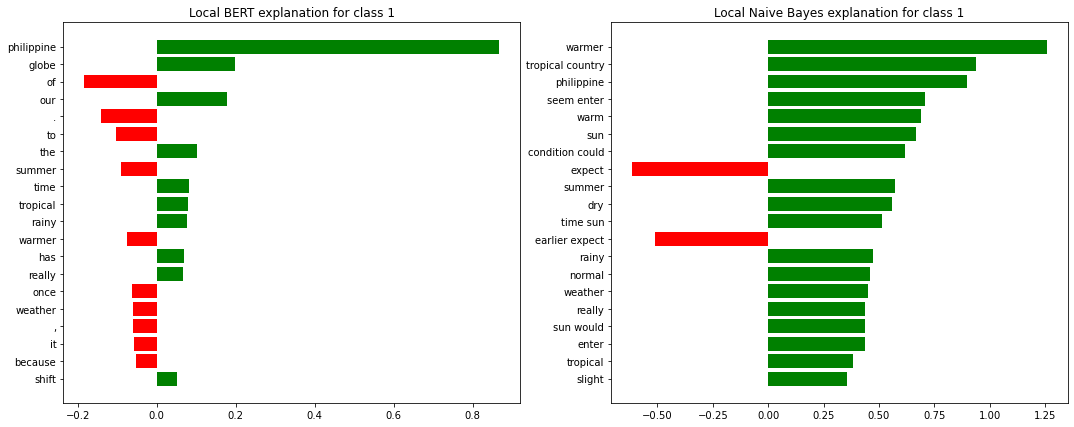

In [14]:
plot_explanations(0, n_features=20)

## Process explanations such that they are comparable

### For IG explanations: join the words that were split by BERT's tokenizer (e.g. 'stack' '##ing' -> 'stacking')

In [15]:
overlap_df.ig[105] #here for instance the word 'discernible' was split into 'disc', '##ern', '##ible'

[('[CLS]', 0.0),
 ('a', -0.13412336918582105),
 ('small', 0.05919924606883617),
 ('island', 0.056827597516987634),
 ('was', -0.11778967454944168),
 ('disc', -0.009601142438474495),
 ('##ern', 0.11476892609759848),
 ('##ible', 0.049852038274164436),
 ('from', 0.08770210193484805),
 ('the', -0.0826688288118328),
 ('distance', 0.10019387912556436),
 (',', -0.21160238019935929),
 ('our', 0.6312773781574766),
 ('destination', 0.026208065001468696),
 ('for', -0.026649204110069782),
 ('that', -0.026541898069335105),
 ('day', 0.046524507878684285),
 ('.', -0.20774079483264374),
 ('for', -0.02582224833591325),
 ('locals', 0.15390649100617357),
 ('and', -0.10648014567785773),
 ('divers', 0.26556557095118427),
 (',', 0.15450012707257724),
 ('that', -0.21186373895207783),
 ('was', 0.09756782945383927),
 ('ap', -0.01853261384565929),
 ('##o', -0.048752542914083236),
 ('island', 0.04908856437756199),
 (',', -0.006500864912867023),
 ('known', 0.058512828377008747),
 ('for', 0.04814034909194349),
 ('i

In [16]:
def contains_substring(tuple_list, substring):
    for t in tuple_list:
        if t[0].startswith(substring):
            return True
    return False

In [17]:
for idx in range(len(overlap_df.ig)):
    while contains_substring(overlap_df.ig[idx], '##'):
        for i,exp in enumerate(overlap_df.ig[idx]):
            # exp[0]: feature name, exp[1]: feature importance
            if exp[0].startswith('##'):
                new_feat = overlap_df.ig[idx][i-1][0] + exp[0][2:]
                if abs(overlap_df.ig[idx][i-1][1]) > abs(exp[1]):
                    new_attrib = overlap_df.ig[idx][i-1][1]
                else:
                    new_attrib = exp[1]
                overlap_df.at[idx,'ig'][i-1] = (new_feat, new_attrib)
                overlap_df.at[idx,'ig'].pop(i)

#### Also: remove punctuation and stopwords, to make BERT and Naive bayes more comparable

In [18]:
stop_words = stopwords.words('english')
stop_words.append('[CLS]')
stop_words.append('[SEP]')

for idx in range(len(overlap_df.ig)):
    delete = []
    for i,exp in enumerate(overlap_df.ig[idx]):
        if exp[0] in stop_words:
            delete.append(i)
        if exp[0] in string.punctuation:
            delete.append(i)
        if len(exp[0]) < 2 and exp[0] != 'i':
            delete.append(i)
    delete = sorted(set(delete), reverse=True)
    for d in delete:
        overlap_df.at[idx,'ig'].pop(d)

#### Lastly: Lemmatize all features

In [19]:
tag_map = defaultdict(lambda : wordnet.NOUN)
tag_map['J'] = wordnet.ADJ
tag_map['V'] = wordnet.VERB
tag_map['R'] = wordnet.ADV
lemmatizer = WordNetLemmatizer()

for idx in range(len(overlap_df.ig)):
    for i,exp in enumerate(overlap_df.ig[idx]):
        # exp[0]: feature name, exp[1]: feature importance
        token,tag = pos_tag([exp[0]])[0]
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        if len(lemma) < 2:
            lemma = exp[0]
        overlap_df.at[idx,'ig'][i] = (lemma, exp[1])

In [20]:
overlap_df.ig[105]

[('small', 0.05919924606883617),
 ('island', 0.056827597516987634),
 ('discernible', 0.11476892609759848),
 ('distance', 0.10019387912556436),
 ('destination', 0.026208065001468696),
 ('day', 0.046524507878684285),
 ('local', 0.15390649100617357),
 ('diver', 0.26556557095118427),
 ('apo', -0.048752542914083236),
 ('island', 0.04908856437756199),
 ('know', 0.058512828377008747),
 ('rich', 0.030385023479251597),
 ('underwater', 0.2851882503324004),
 ('life', -0.2241755798801522)]

A small island was discernible from the distance, our destination for that day. For locals and divers, that was Apo Island, known for its rich underwater life.  

A small island was discernible from the distance, our destination for that day. For locals and divers, that was Apo Island, known for its rich underwater life.  

True label = 1


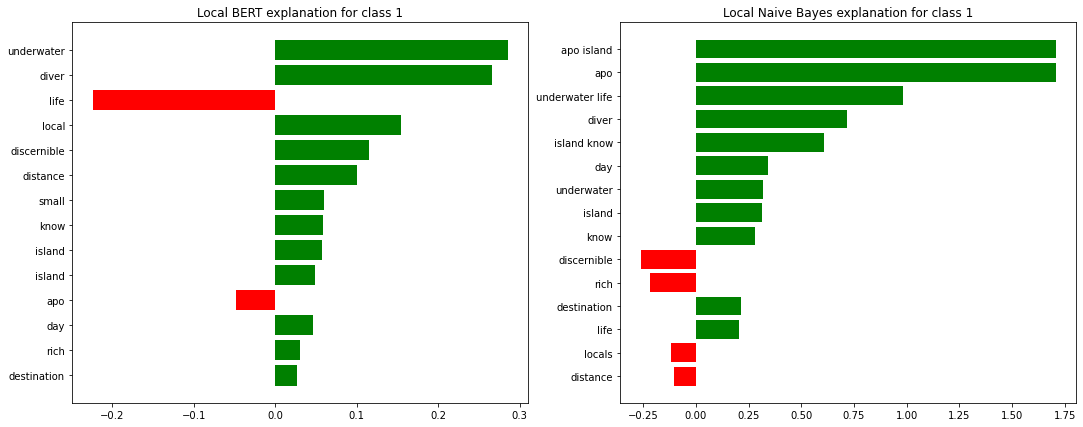

In [21]:
print(overlap_df.post[105], "\n")
plot_explanations(105)

## For each explanation: Extract top *X* features and calculate overlap

In [22]:
# Calculating overlap:
# only features that are important for the same class: I.e. do not count features if BERT considers it to be male whereas Naive Bayes as female
# also count BERT features that occur in Bayes' bigrams and trigrams (e.g. "skin" and "skin tone" are an overlap)

def find_in_nested_list(item, nested_list):
    for sub_list in nested_list:
        if item in sub_list:
            #return (nested_list.index(sub_list), sub_list.index(char))
            return nested_list.index(sub_list)
    raise ValueError("'{string}' is not in list".format(string = item))
    
def overlap(sample_id, n_feat=25):
    sample = overlap_df.iloc[sample_id]
    top_bert = sorted(sample.ig, key=lambda x: abs(x[1]), reverse=True)[:n_feat]
    top_bayes = sorted(sample.nb_exp, key=lambda x: abs(x[1]), reverse=True)[:n_feat]

    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]
    bayes_feat = [t[0].split() for t in top_bayes]
    if sample.pred == sample.nb_pred:
        bayes_attrib = [t[1] for t in top_bayes]
    else:
        bayes_attrib = [-t[1] for t in top_bayes]

    overlap = []
    opposing = []
    for i,feat in enumerate(bert_feat): 
        if any(feat in sublist for sublist in bayes_feat):
            bayes_idx = find_in_nested_list(feat, bayes_feat)
            if np.sign(bert_attrib[i]) == np.sign(bayes_attrib[bayes_idx]):
                overlap.append(feat)
            else:
                opposing.append(feat)

    overlap_ratio = len(overlap)/len(bert_feat)  #unsure if set(overlap)?
    return (overlap_ratio, overlap, opposing) #unsure if set(overlap) and set(opposing) should be used?

All facials follow the same basic structure and order. They will begin with makeup removal and cleansing. The cleansing is normally repeated twice to ensure it is thorough. Then comes some method of exfoliation to remove dead skin cells and smooth the surface of the skin. A massage is then performed that can include all or some of the scalp, face, neck, shoulders, back and even the hands or feet. Next a mask is applied, chosen according to the client’s specific skin type. Once the mask has been removed the skin is toned and the final eye, neck and face creams are applied. 

True label = 1


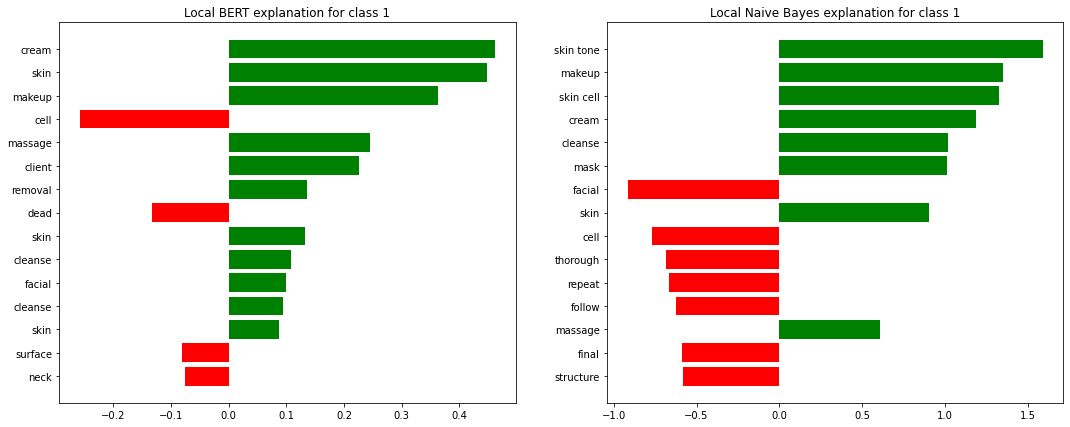

In [23]:
plot_explanations(7)

In [24]:
test = overlap(sample_id=7)
print("Overlap =" , test[0], "% :", test[1])
print("Opposing words =" , test[2])

Overlap = 0.56 % : ['cream', 'skin', 'makeup', 'massage', 'removal', 'skin', 'cleanse', 'cleanse', 'skin', 'neck', 'structure', 'order', 'neck', 'skin']
Opposing words = ['cell', 'dead', 'facial', 'smooth', 'mask']


In [25]:
# calculate overlap for all data samples
overlap_ratio = []
overlap_words = []
opposing_words = []
N_FEAT = 20

for idx,sample in overlap_df.iterrows():
    res = overlap(idx, N_FEAT)
    overlap_ratio.append(res[0]) 
    overlap_words.append(res[1])
    opposing_words.extend(res[2])

In [26]:
overlap_df['overlap'] = overlap_ratio
overlap_df['overlap_words'] = overlap_words
overlap_df.to_csv('../data/overlap_df.csv', index=False)

In [27]:
print("Mean:", np.mean(overlap_df.overlap), "%")
print("Median:", np.median(overlap_df.overlap), "%")
print("Max:", max(overlap_df.overlap), "%")

Mean: 0.34694418739155597 %
Median: 0.35 %
Max: 0.8 %


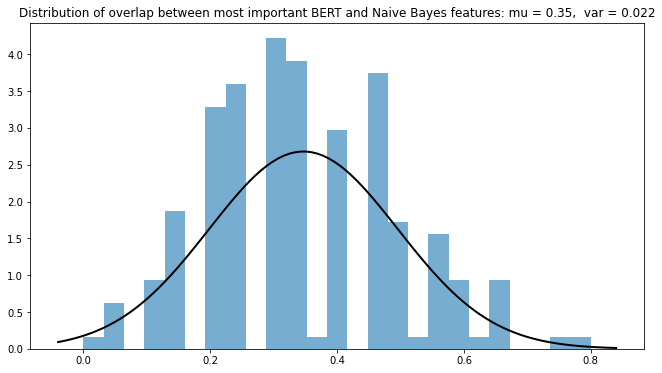

In [28]:
# Plot the histogram.
mu, std = norm.fit(overlap_df.overlap)
plt.figure(figsize=(11,6))
plt.hist(overlap_df.overlap, bins=25, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Distribution of overlap between most important BERT and Naive Bayes features: mu = %.2f,  var = %.3f" % (mu, std**2)
plt.title(title)
plt.show()

### Wordcloud from female and male overlap

In [29]:
female = []
for l in overlap_df.overlap_words[overlap_df['pred'] == 1]:
    female.extend(l)

male = []
for l in overlap_df.overlap_words[overlap_df['pred'] == 0]:
    male.extend(l)

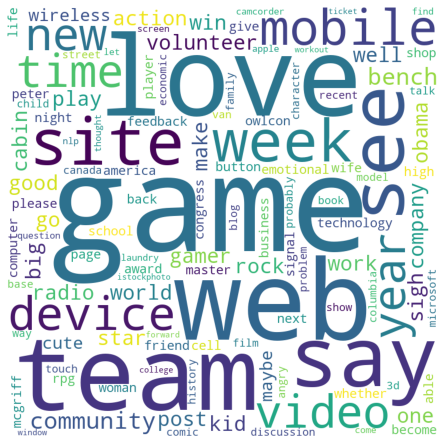

In [30]:
comment_words = " ".join(male)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

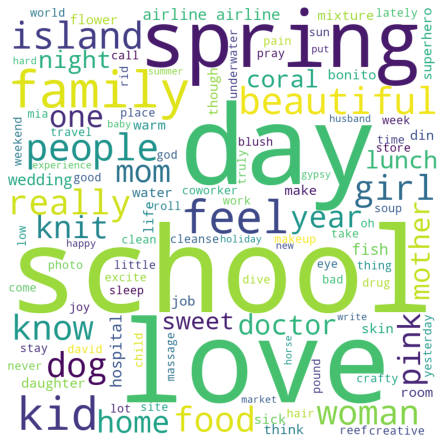

In [31]:
comment_words = " ".join(female)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white',
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

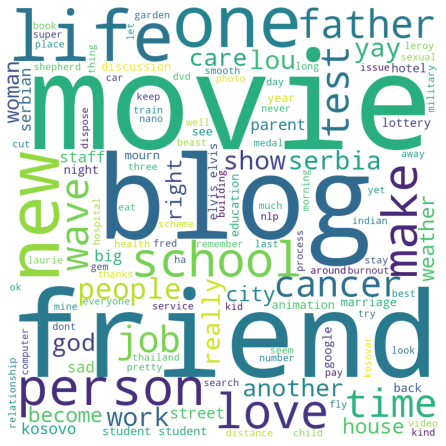

In [32]:
comment_words = " ".join(opposing_words)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white',
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Look specifically for male and female overlap

In [41]:
male_overlap = []
female_overlap = []
N_FEAT = 15

for idx,sample in overlap_df.iterrows():
    top_bert = sorted(sample.ig, key=lambda x: x[1], reverse=True)[:N_FEAT]
    bert_feat = [t[0] for t in top_bert]
    bert_attrib = [t[1] for t in top_bert]
    
    if sample.pred == sample.nb_pred:
        top_bayes = sorted(sample.nb_exp, key=lambda x: x[1], reverse=True)[:N_FEAT]
        bayes_feat = [t[0].split() for t in top_bayes]
        bayes_attrib = [t[1] for t in top_bayes]
    else:
        top_bayes = sorted(sample.nb_exp, key=lambda x: x[1], reverse=False)[:N_FEAT]
        bayes_feat = [t[0].split() for t in top_bayes]
        bayes_attrib = [-t[1] for t in top_bayes]        
    
    for i,feat in enumerate(bert_feat):
        if any(feat in sublist for sublist in bayes_feat):
            bayes_idx = find_in_nested_list(feat, bayes_feat)
            if np.sign(bert_attrib[i]) == np.sign(bayes_attrib[bayes_idx]) == 1:
                if sample.pred == 0:
                    male_overlap.append(feat)
                else:
                    female_overlap.append(feat)
            if np.sign(bert_attrib[i]) == np.sign(bayes_attrib[bayes_idx]) == -1:
                if sample.pred == 0:
                    female_overlap.append(feat)
                else:
                    male_overlap.append(feat)

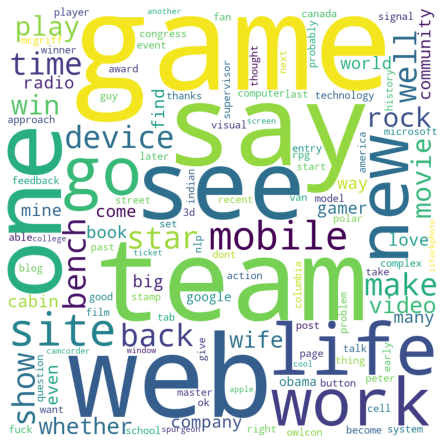

In [42]:
comment_words = " ".join(male_overlap)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white',
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

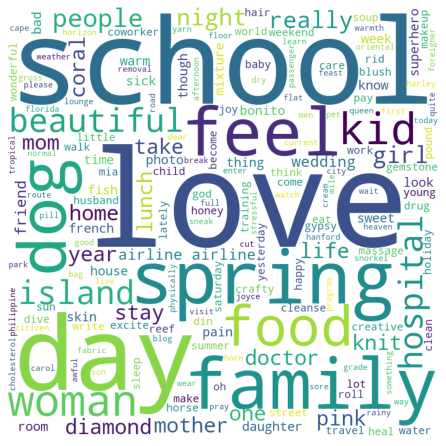

In [35]:
comment_words = " ".join(female_overlap)
wordcloud = WordCloud(width = 800, height = 800,
                background_color='white',
                min_font_size=15, max_font_size=250).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6,6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Explanation plots

Living with roommates is a very unique experience. However it is up to you how you go about it. Your house can be like a hotel with different people staying in it, minding their own business, cooking for themselves or it can be a wonderful, funny place. A real home away from home. That happens when you make an effort to connect with your roomies and make it a point to do some things together. My seniors have always managed to cheer me up every time I felt down. Life here for me has been filled with moments of homesickness. Disappointments. Depression. Hunger. Financial crunch... And yet I laugh at most times and bury myself in work at the other times. A bunch of seniors who have helped me out since the day i landed are...  Life is fast right now. I wake up each day and by the time I crash down again, all is a blur. I still can't digest that it has been two whole months since I boarded that flight from Muscat and arrived at Chicago- not knowing a soul here! Life gets tough once in a whi

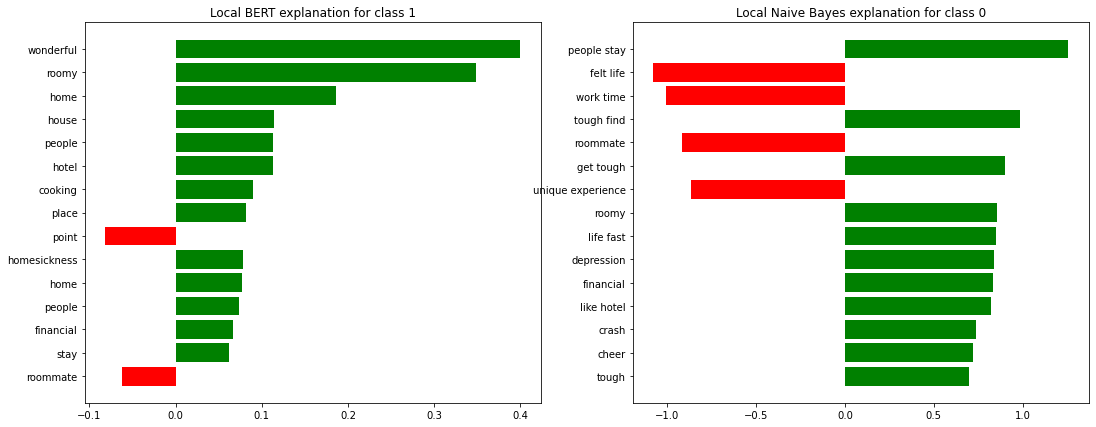

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
124,399,Living with roommates is a very unique experie...,1,"[(living, 0.02052028718298198), (roommate, -0....",Living with roommates is a very unique experie...,1,0.071533,212,"['live', 'roommate', 'unique', 'experience', '...","[(yet, -0.09989433279642768, -9.74983456213791...",0,0.15,"[day, day, experience]"


In [36]:
i = 124
plot_explanations(i)
overlap_df[overlap_df.index == i]

30 Rock is a very...unique...show.  It's very easy to see why the Emmys flock to it like tweens to a Taylor Lautner poster; there's simply nothing else like it on TV.  A show like The Office usually goes out for more obvious discomfort-related gags, while 30 Rock engages a much more rapid-fire hit and miss of total absurdity.  It's been a few weeks since we've seen lachrymose Liz Lemon, even after the Olympics, and I can honestly say I missed the witty offbeat charm 30 Rock does so well.

 

True label = 0


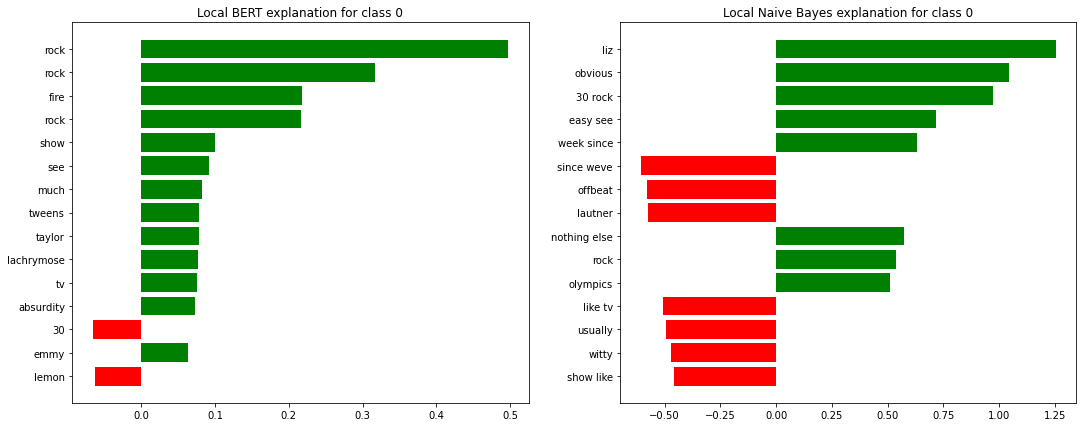

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
8,17,30 Rock is a very...unique...show. It's very ...,0,"[(30, -0.03407788072869303), (rock, 0.49668696...",30 Rock is a very...unique...show. It's very ...,0,0.072565,89,"['30', 'rock', 'veryuniqueshow', 'easy', 'see'...","[(witty, -0.47227810913473967, -12.65645244834...",0,0.25,"[rock, rock, rock, see, since]"


In [37]:
i = 8
plot_explanations(i)
overlap_df[overlap_df.index == i]

I picked her up on Saturday, after a night of lots of partying and little sleeping. Yes, I'm gangster. We didn't get home until 5 in th morning on Sunday. We had lots of fun. We kayaked, shopped, tried on tons of clothes in a co-ed dressing room (I got caught by a male worker in my bra, then later, dancing retardedly - sweet! as in, embarrassing), went on rescue missions with the boys (rescued a boat load of unshaven, smelly, barefoot.. hippies! The stinkiest rescue mission of all time, thanks Bob!), got pedicures, paddled at midnight to see phosphorescence, oogled hot guys, barbecued at Jays, crashed a dinner party at Tugboat Annies...  and I even got away with some stuff that I'd never have gotten away with if Joshlynn wasn't there. Like taking pictures of ourselves in the round mirror in the middle of the marina store. 

True label = 1


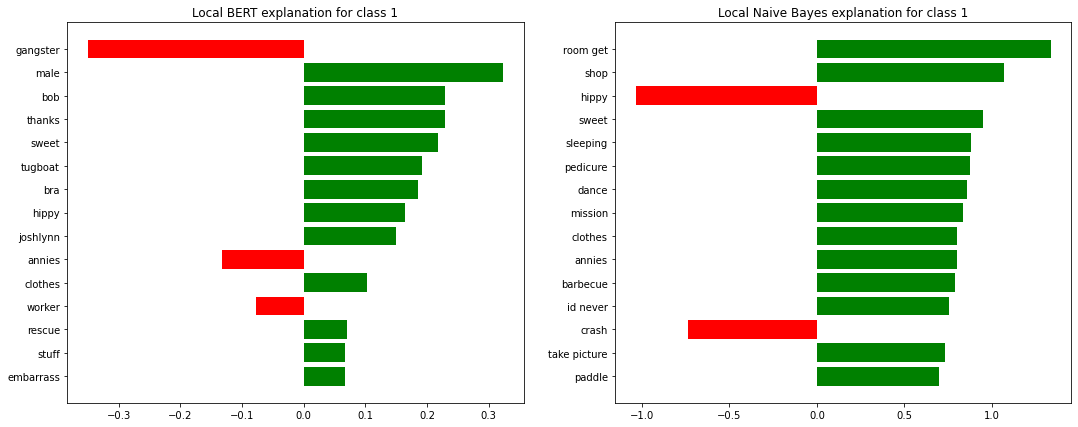

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
98,322,"I picked her up on Saturday, after a night of ...",1,"[(picked, -0.020465867534254615), (saturday, -...","I picked her up on Saturday, after a night of ...",1,0.003938,148,"['pick', 'saturday', 'night', 'lot', 'party', ...","[(yes im, 0.16268920774395212, -12.41001793246...",1,0.2,"[sweet, bra, clothes, rescue]"


In [38]:
i = 98
plot_explanations(i)
overlap_df[overlap_df.index == i]

A small island was discernible from the distance, our destination for that day. For locals and divers, that was Apo Island, known for its rich underwater life.  

True label = 1


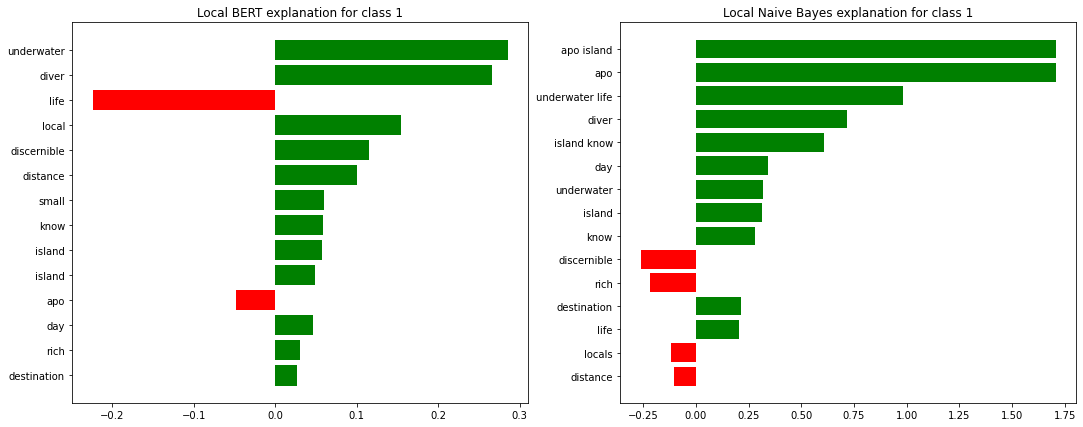

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
105,353,A small island was discernible from the distan...,1,"[(small, 0.05919924606883617), (island, 0.0568...",A small island was discernible from the distan...,1,0.097079,27,"['small', 'island', 'discernible', 'distance',...","[(underwater life, 0.980552413772358, -13.4025...",1,0.571429,"[underwater, diver, small, know, island, islan..."


In [39]:
i = 105
plot_explanations(i)
overlap_df[overlap_df.index == i]

I am not the typical RPG gamer. I have never been a fan of the games where you pick your actions from a menu. This is a real-time RPG. It is wide open from the begining, although one might want to watch where they venture. High-level nasties, and locked doors may block your way. If you are a mage, dispatching the baddies will come easier. If you are a theif, you can take care of those pesky locks with ease. But, your class is not limited. 

True label = 0


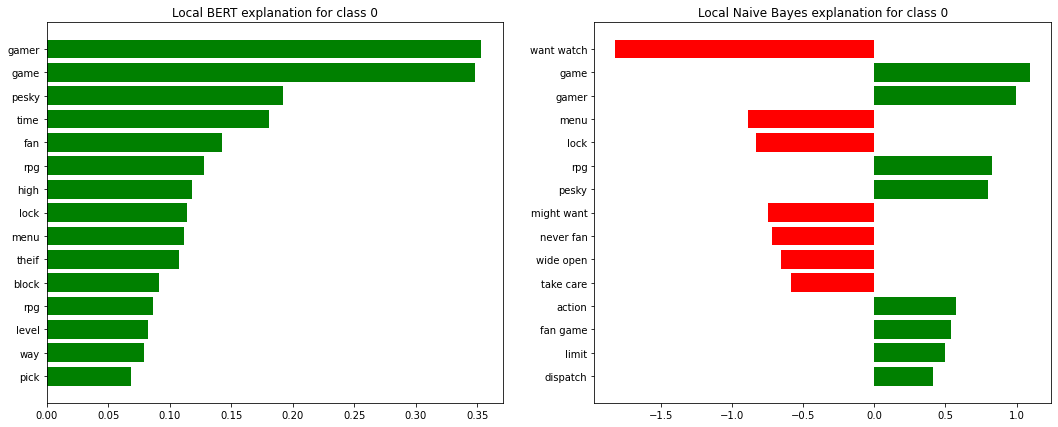

,df_test_index,post,label,ig,truncated,pred,ig_accuracy,post_lengths,tokenized,nb_exp,nb_pred,overlap,overlap_words
49,138,I am not the typical RPG gamer. I have never b...,0,"[(typical, 0.05471321374179136), (rpg, 0.08629...",I am not the typical RPG gamer. I have never b...,0,-0.002828,86,"['typical', 'rpg', 'gamer', 'never', 'fan', 'g...","[(wide open, -0.6581523136980838, -13.25865663...",0,0.3,"[gamer, game, pesky, rpg, rpg, action]"


In [40]:
i = 49
plot_explanations(i)
overlap_df[overlap_df.index == i]